# Codelab for Data Cleaning

### Background Information

1.Data from 2008-2016 10 European countary top league

2.Match result includes date,home team, away team, bet odds for several website.

3.Not pass game result history data in the data set

4.The prediction mainly depends on the pre-game bet odds shown in the match result data

5.By aggregating data by district, we can use the district mapping data to plot district-by-district differences.

### Index

1. [Input Data](#Input-Data)
2. [Condensing Data](#Condensing-Data)
3. [Merging Dataset](#Merging-Dataset)
4. [Unifying Feature](#Unifying-feature)
5. [Deleting Leak Features](#Deleting-Leak-Feature)
6. [Cleaning One Hot Features](#Cleaning-One-hot-features)
7. [Correlation Between Bet Odd and Match Result](#Correlation-Between-Bet-Odd-and-Match-Result)
8. [Saving Data to CSV File](#Saving-Data-to-CSV-File)

In [19]:
import pandas as pd
import numpy as np
import sqlite3
%matplotlib inline
path = 'Data/soccer.sqlite'
conn = sqlite3.connect(path)

## Input Data

In [2]:
################################################################################
#######################Read Raw Data from DB####################################
################################################################################

data_matchResult = pd.read_sql('SELECT country_id, league_id, season, date,\
                                home_team_api_id, away_team_api_id, home_team_goal, away_team_goal,\
                                B365H, B365D, B365A, BWH, BWD, BWA, IWH, IWD, IWA,\
                                LBH, LBD, LBA, WHH, WHD, WHA, VCH, VCD, VCA FROM Match',conn)
                                
data_country = pd.read_sql('SELECT * From Country',conn)
data_team = pd.read_sql('SELECT team_api_id, date, buildUpPlaySpeed, buildUpPlayPassing,\
                         chanceCreationPassing, chanceCreationCrossing, chanceCreationShooting,\
                         defencePressure, defenceAggression, defenceTeamWidth From Team_Attributes' ,conn)


## Condensing Data

In [3]:
################################################################################
#######################Merge Team Attribute to Mach Result######################
################################################################################


#######Filter Function#########
def mask(df, key, value):
    return df[df[key] == value]
pd.DataFrame.mask = mask
###############################


################################################################################
###################Generate Homd/Away Team Attribute############################

for index, row in data_team.iterrows():
    data_team.ix[index,'date'] = int(data_team.ix[index,'date'][:4])

    
for index, row in data_matchResult.iterrows():
    data_matchResult.ix[index, 'date'] = int(data_matchResult.ix[index,'date'][:4])

data_team = data_team.dropna()
data_awayTeam = data_team
data_homeTeam = data_team
away_name = {}
home_name = {}

for c in data_awayTeam.columns:
    name = 'away_' + str(c)
    away_name[c] = name
    
for c in data_homeTeam.columns:
    name = 'home_' + str(c)
    home_name[c] = name
    
away_name['date'] = 'date'
home_name['date'] = 'date'

data_awayTeam = data_awayTeam.rename(columns = away_name)
data_homeTeam = data_homeTeam.rename(columns = home_name)

data_matchResult = data_matchResult.dropna()



In [4]:
data_matchResult.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22432 entries, 0 to 24556
Data columns (total 26 columns):
country_id          22432 non-null int64
league_id           22432 non-null int64
season              22432 non-null object
date                22432 non-null object
home_team_api_id    22432 non-null int64
away_team_api_id    22432 non-null int64
home_team_goal      22432 non-null int64
away_team_goal      22432 non-null int64
B365H               22432 non-null float64
B365D               22432 non-null float64
B365A               22432 non-null float64
BWH                 22432 non-null float64
BWD                 22432 non-null float64
BWA                 22432 non-null float64
IWH                 22432 non-null float64
IWD                 22432 non-null float64
IWA                 22432 non-null float64
LBH                 22432 non-null float64
LBD                 22432 non-null float64
LBA                 22432 non-null float64
WHH                 22432 non-null float64
WH

## Merging Dataset

In [5]:
################################################################################
###################Merge Home/Teamm Attribute to Match Reslt####################


full = data_matchResult
full = pd.merge(full, data_homeTeam, how = 'left', on = ['date', 'home_team_api_id'] )

################################################################################
#########Fill the missing season team data with average team data###############
full = full.groupby("home_team_api_id").transform(lambda x: x.fillna(x.mean()))

full = pd.merge(full, data_awayTeam, how = 'left', on = ['date', 'away_team_api_id'] )
full = full.groupby("away_team_api_id").transform(lambda x: x.fillna(x.mean()))

## Unifying feature

In [6]:
################################################################################
#################Unifying Data,convert objective columns to numerical###########
full = full.convert_objects(convert_numeric=True)

################################################################################
###########################Drop unnecessary columns#############################

full = full.drop(labels = ['date'], axis=1)
full = full.dropna()


/home/dawei/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()


## Deleting leak feature


In [7]:
################################################################################
###########################Adding match Result##################################
sLength = len(full)
full['match_result'] = pd.Series(np.random.randn(sLength), index=full.index)
#full['match_result'] = full['match_result'].astype(object)

for index, row in full.iterrows():
    homeGoal = full.ix[index,'home_team_goal']
    awayGoal = full.ix[index,'away_team_goal']
    
    if homeGoal > awayGoal:
        full.set_value(index,'match_result',0)
    elif homeGoal == awayGoal:
        full.set_value(index,'match_result',1)
    elif homeGoal < awayGoal:
        full.set_value(index,'match_result',2)
    


In [8]:
full = full.drop(labels = ['home_team_goal','away_team_goal'], axis=1)

## Cleaning One-hot features

In [9]:
full.columns

Index([u'country_id', u'league_id', u'B365H', u'B365D', u'B365A', u'BWH',
       u'BWD', u'BWA', u'IWH', u'IWD', u'IWA', u'LBH', u'LBD', u'LBA', u'WHH',
       u'WHD', u'WHA', u'VCH', u'VCD', u'VCA', u'home_buildUpPlaySpeed',
       u'home_buildUpPlayPassing', u'home_chanceCreationPassing',
       u'home_chanceCreationCrossing', u'home_chanceCreationShooting',
       u'home_defencePressure', u'home_defenceAggression',
       u'home_defenceTeamWidth', u'away_buildUpPlaySpeed',
       u'away_buildUpPlayPassing', u'away_chanceCreationPassing',
       u'away_chanceCreationCrossing', u'away_chanceCreationShooting',
       u'away_defencePressure', u'away_defenceAggression',
       u'away_defenceTeamWidth', u'match_result'],
      dtype='object')

In [10]:
col=['country_id','league_id']
for c in col:
    full[c]=full[c].astype('category')
dummy_df=pd.get_dummies(full[col])
full=pd.concat([full,dummy_df],axis=1)
dummy_df.head()
full = full.drop(col, axis=1)

## Correlation Between Bet Odd and Match Result

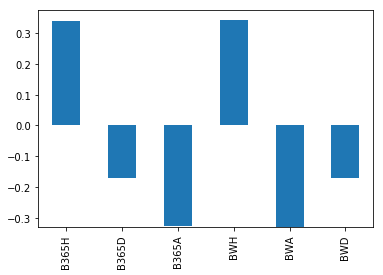

In [20]:
full.corr()['match_result'][['B365H','B365D','B365A','BWH','BWA','BWD']].plot.bar()

## Saving Data to CSV File

In [ ]:
full.to_csv('Processed/cleaned_data.csv', index=False,low_memory=False)